# 라이브러리 임포트

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
import pandas as pd

from models.VAE import VariationalAutoencoder
from utils.loaders import load_model, ImageLabelLoader

In [11]:
# run params
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])

DATA_FOLDER = './data/celeb/'
IMAGE_FOLDER = './data/celeb/img_align_celeba/'

JC_IMAGE_FOLDER = './data/celeb/input_image/'

# 데이터 적재

In [12]:
INPUT_DIM = (128,128,3)

att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))
JC_csv = pd.read_csv(os.path.join(DATA_FOLDER, 'input.csv'))

imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])
JC_imageLoader = ImageLabelLoader(JC_IMAGE_FOLDER, INPUT_DIM[:2])


# 모델만들기

In [13]:
vae = load_model(VariationalAutoencoder, RUN_FOLDER)

In [14]:
n_to_show=10
data_flow_generic = imageLoader.build(att, n_to_show)
JC_data_flow_generic = JC_imageLoader.build(JC_csv, n_to_show)

Found 202599 validated image filenames.
Found 1 validated image filenames.


C:\Users\samsung\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 2 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


# 새로 생성한 얼굴

In [15]:
def get_vector_from_label(label, batch_size):

    data_flow_label = imageLoader.build(att, batch_size, label = label)
   
    origin = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
       
        im = batch[0]
     
        attribute = batch[1]
    
        z = vae.encoder.predict(np.array(im))

        z_POS = z[attribute==1]   
        z_NEG = z[attribute==-1]
    
        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist
        
        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector

In [16]:
def add_vector_to_images(feature_vec):

    n_to_show = 1
    factors = [-4,-3,-2,-1,0,1,2,3,4]
    
    JC_example_batch = next(JC_data_flow_generic)
    JC_example_images = JC_example_batch[0]
    JC_example_labels = JC_example_batch[1]

    JC_z_points = vae.encoder.predict(JC_example_images)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = JC_example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = JC_z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1
    
    plt.show()

In [17]:
BATCH_SIZE = 00
male_vec = get_vector_from_label('Male', BATCH_SIZE)
black_hair_vec= get_vector_from_label('Black_Hair', BATCH_SIZE)
blonde_hair_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)
brown_hair_vec= get_vector_from_label('Brown_Hair', BATCH_SIZE)
gray_hair_vec= get_vector_from_label('Gray_Hair', BATCH_SIZE)
straight_hair_vec= get_vector_from_label('Straight_Hair', BATCH_SIZE)
wavy_hair_vec= get_vector_from_label('Wavy_Hair', BATCH_SIZE)
heavy_makeup_vec= get_vector_from_label('Heavy_Makeup', BATCH_SIZE)
mustache_vec= get_vector_from_label('Mustache', BATCH_SIZE)
wearing_hat_vec= get_vector_from_label('Wearing_Hat', BATCH_SIZE)
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)
# print(r_loss.shape)
#print(example_batch)
#print(JC_example_batch)

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Male
images : POS move : NEG move :distance : 𝛥 distance
213    : 1.168    : 1.026    : 1.794    : 1.794
436    : 0.76    : 0.611    : 1.515    : -0.279
648    : 0.358    : 0.322    : 1.388    : -0.127
854    : 0.254    : 0.239    : 1.34    : -0.048
1067    : 0.236    : 0.187    : 1.298    : -0.041
1287    : 0.181    : 0.145    : 1.29    : -0.008
1504    : 0.143    : 0.132    : 1.275    : -0.015
1716    : 0.144    : 0.108    : 1.273    : -0.002
1937    : 0.112    : 0.101    : 1.279    : 0.006
2148    : 0.091    : 0.084    : 1.285    : 0.006
2357    : 0.09    : 0.077    : 1.285    : -0.0
2547    : 0.078    : 0.075    : 1.273    : -0.012
2768    : 0.076    : 0.062    : 1.269    : -0.004
2990    : 0.083    : 0.062    : 1.255    : -0.014
3214    : 0.069    : 0.062    : 1.249    : -0.006
3413    : 0.06    : 0.052    : 1.252    : 0.003
3600    : 0.056    : 0.053    : 1.25    : -0.002
3820    : 0.051    : 0.046    : 1.25    : -0.0
4024    : 0.052

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Black_Hair
images : POS move : NEG move :distance : 𝛥 distance
122    : 1.407    : 0.718    : 1.662    : 1.662
246    : 0.89    : 0.494    : 1.395    : -0.267
359    : 0.515    : 0.31    : 1.269    : -0.126
475    : 0.412    : 0.193    : 1.166    : -0.103
594    : 0.279    : 0.16    : 1.131    : -0.035
705    : 0.223    : 0.131    : 1.115    : -0.016
815    : 0.193    : 0.114    : 1.117    : 0.001
939    : 0.168    : 0.1    : 1.111    : -0.006
1057    : 0.156    : 0.091    : 1.106    : -0.005
1180    : 0.13    : 0.078    : 1.103    : -0.003
1324    : 0.13    : 0.067    : 1.112    : 0.009
1439    : 0.118    : 0.064    : 1.108    : -0.005
1546    : 0.089    : 0.06    : 1.094    : -0.014
1666    : 0.091    : 0.056    : 1.086    : -0.008
1771    : 0.086    : 0.049    : 1.08    : -0.006
1900    : 0.091    : 0.047    : 1.072    : -0.009
2025    : 0.083    : 0.043    : 1.078    : 0.006
2148    : 0.078    : 0.041    : 1.081    : 0.002
2271    : 0.

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
55    : 2.112    : 0.687    : 2.279    : 2.279
116    : 1.349    : 0.443    : 1.969    : -0.31
191    : 0.825    : 0.298    : 1.749    : -0.219
261    : 0.507    : 0.188    : 1.699    : -0.05
345    : 0.426    : 0.137    : 1.631    : -0.068
436    : 0.321    : 0.118    : 1.561    : -0.071
509    : 0.239    : 0.109    : 1.537    : -0.023
587    : 0.197    : 0.085    : 1.525    : -0.012
666    : 0.179    : 0.084    : 1.518    : -0.007
733    : 0.157    : 0.071    : 1.506    : -0.013
789    : 0.14    : 0.058    : 1.502    : -0.004
873    : 0.153    : 0.055    : 1.507    : 0.005
949    : 0.126    : 0.053    : 1.518    : 0.011
1015    : 0.114    : 0.051    : 1.5    : -0.018
1092    : 0.109    : 0.049    : 1.489    : -0.011
1147    : 0.087    : 0.047    : 1.49    : 0.001
1223    : 0.095    : 0.042    : 1.478    : -0.013
1286    : 0.087    : 0.039    : 1.47    : -0.008
1355    : 0.088

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Brown_Hair
images : POS move : NEG move :distance : 𝛥 distance
106    : 1.314    : 0.741    : 1.533    : 1.533
206    : 0.875    : 0.517    : 1.203    : -0.33
319    : 0.525    : 0.305    : 1.08    : -0.123
426    : 0.379    : 0.207    : 1.019    : -0.061
539    : 0.319    : 0.163    : 0.926    : -0.093
638    : 0.249    : 0.133    : 0.862    : -0.064
722    : 0.198    : 0.108    : 0.845    : -0.017
823    : 0.174    : 0.101    : 0.816    : -0.029
930    : 0.181    : 0.084    : 0.777    : -0.039
1028    : 0.139    : 0.077    : 0.751    : -0.026
1132    : 0.124    : 0.065    : 0.737    : -0.014
1237    : 0.118    : 0.066    : 0.715    : -0.022
1342    : 0.107    : 0.063    : 0.711    : -0.005
1441    : 0.089    : 0.052    : 0.709    : -0.001
1542    : 0.097    : 0.048    : 0.7    : -0.01
1632    : 0.07    : 0.045    : 0.693    : -0.006
1741    : 0.093    : 0.041    : 0.689    : -0.004
1833    : 0.079    : 0.039    : 0.681    : -0.008
1934  

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Gray_Hair
images : POS move : NEG move :distance : 𝛥 distance
18    : 3.756    : 0.636    : 3.866    : 3.866
42    : 2.58    : 0.432    : 2.736    : -1.13
66    : 1.266    : 0.248    : 2.34    : -0.396
85    : 0.81    : 0.174    : 2.197    : -0.143
112    : 0.744    : 0.142    : 2.008    : -0.189
131    : 0.502    : 0.115    : 1.913    : -0.095
153    : 0.481    : 0.099    : 1.893    : -0.02
167    : 0.322    : 0.079    : 1.848    : -0.045
188    : 0.349    : 0.074    : 1.816    : -0.032
215    : 0.356    : 0.066    : 1.794    : -0.022
233    : 0.248    : 0.059    : 1.796    : 0.002
254    : 0.252    : 0.061    : 1.798    : 0.002
278    : 0.258    : 0.049    : 1.785    : -0.014
298    : 0.224    : 0.048    : 1.783    : -0.002
321    : 0.216    : 0.043    : 1.8    : 0.017
343    : 0.202    : 0.039    : 1.806    : 0.006
364    : 0.2    : 0.039    : 1.79    : -0.017
382    : 0.16    : 0.038    : 1.784    : -0.006
400    : 0.157    : 0.035    

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Straight_Hair
images : POS move : NEG move :distance : 𝛥 distance
122    : 1.257    : 0.785    : 1.495    : 1.495
235    : 0.797    : 0.522    : 1.122    : -0.373
323    : 0.477    : 0.285    : 0.994    : -0.128
431    : 0.42    : 0.202    : 0.865    : -0.129
539    : 0.275    : 0.16    : 0.769    : -0.096
650    : 0.257    : 0.138    : 0.711    : -0.058
750    : 0.211    : 0.113    : 0.684    : -0.026
858    : 0.183    : 0.087    : 0.673    : -0.012
960    : 0.151    : 0.084    : 0.647    : -0.026
1062    : 0.141    : 0.067    : 0.639    : -0.008
1172    : 0.119    : 0.065    : 0.619    : -0.02
1297    : 0.124    : 0.063    : 0.607    : -0.013
1415    : 0.114    : 0.053    : 0.603    : -0.004
1523    : 0.107    : 0.055    : 0.601    : -0.002
1620    : 0.094    : 0.048    : 0.592    : -0.009
1718    : 0.081    : 0.045    : 0.585    : -0.007
1819    : 0.079    : 0.046    : 0.563    : -0.021
1919    : 0.073    : 0.039    : 0.552    : -0.011


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Wavy_Hair
images : POS move : NEG move :distance : 𝛥 distance
165    : 1.198    : 0.838    : 1.53    : 1.53
316    : 0.742    : 0.566    : 1.247    : -0.284
492    : 0.448    : 0.317    : 1.151    : -0.096
654    : 0.307    : 0.221    : 1.074    : -0.077
811    : 0.255    : 0.17    : 1.031    : -0.043
968    : 0.195    : 0.133    : 1.01    : -0.021
1139    : 0.191    : 0.126    : 0.98    : -0.03
1301    : 0.155    : 0.101    : 0.977    : -0.003
1448    : 0.12    : 0.09    : 0.947    : -0.03
1616    : 0.118    : 0.077    : 0.943    : -0.004
1815    : 0.111    : 0.072    : 0.928    : -0.015
1963    : 0.093    : 0.069    : 0.939    : 0.011
2126    : 0.088    : 0.061    : 0.931    : -0.008
2294    : 0.077    : 0.055    : 0.929    : -0.003
2445    : 0.064    : 0.05    : 0.927    : -0.002
2607    : 0.065    : 0.048    : 0.933    : 0.006
2783    : 0.07    : 0.042    : 0.924    : -0.009
2951    : 0.068    : 0.046    : 0.917    : -0.008
3120    : 0

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Heavy_Makeup
images : POS move : NEG move :distance : 𝛥 distance
205    : 1.249    : 0.874    : 1.671    : 1.671
392    : 0.627    : 0.55    : 1.464    : -0.207
609    : 0.423    : 0.314    : 1.339    : -0.125
792    : 0.273    : 0.236    : 1.308    : -0.031
968    : 0.221    : 0.18    : 1.264    : -0.044
1177    : 0.183    : 0.143    : 1.228    : -0.036
1374    : 0.141    : 0.123    : 1.225    : -0.004
1574    : 0.137    : 0.104    : 1.215    : -0.01
1771    : 0.115    : 0.088    : 1.214    : -0.001
1980    : 0.102    : 0.09    : 1.218    : 0.004
2179    : 0.09    : 0.077    : 1.207    : -0.011
2383    : 0.081    : 0.069    : 1.202    : -0.005
2575    : 0.081    : 0.066    : 1.2    : -0.002
2775    : 0.072    : 0.055    : 1.193    : -0.007
2961    : 0.067    : 0.055    : 1.188    : -0.005
3158    : 0.069    : 0.057    : 1.185    : -0.003
3351    : 0.06    : 0.05    : 1.184    : -0.001
3544    : 0.053    : 0.047    : 1.179    : -0.006
3736

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Mustache
images : POS move : NEG move :distance : 𝛥 distance
17    : 3.734    : 0.706    : 3.837    : 3.837
39    : 2.673    : 0.484    : 2.476    : -1.361
63    : 1.42    : 0.243    : 2.111    : -0.364
85    : 0.816    : 0.183    : 1.912    : -0.199
107    : 0.707    : 0.148    : 1.733    : -0.179
132    : 0.567    : 0.118    : 1.667    : -0.066
153    : 0.457    : 0.088    : 1.602    : -0.065
178    : 0.476    : 0.085    : 1.58    : -0.022
198    : 0.304    : 0.076    : 1.522    : -0.058
225    : 0.356    : 0.065    : 1.462    : -0.06
248    : 0.275    : 0.059    : 1.398    : -0.064
272    : 0.263    : 0.057    : 1.384    : -0.013
287    : 0.192    : 0.053    : 1.374    : -0.011
308    : 0.219    : 0.045    : 1.353    : -0.021
331    : 0.218    : 0.045    : 1.363    : 0.01
351    : 0.192    : 0.038    : 1.369    : 0.006
366    : 0.152    : 0.04    : 1.363    : -0.006
383    : 0.157    : 0.04    : 1.345    : -0.018
408    : 0.194    : 0.0

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Wearing_Hat
images : POS move : NEG move :distance : 𝛥 distance
25    : 3.347    : 0.706    : 3.465    : 3.465
48    : 2.089    : 0.496    : 2.575    : -0.891
72    : 1.354    : 0.277    : 2.206    : -0.369
88    : 0.755    : 0.179    : 2.223    : 0.017
109    : 0.675    : 0.147    : 2.185    : -0.038
126    : 0.52    : 0.121    : 2.111    : -0.074
153    : 0.541    : 0.1    : 1.953    : -0.158
169    : 0.364    : 0.082    : 1.963    : 0.01
197    : 0.39    : 0.074    : 1.937    : -0.026
219    : 0.326    : 0.067    : 1.918    : -0.019
245    : 0.337    : 0.06    : 1.892    : -0.026
266    : 0.271    : 0.055    : 1.894    : 0.002
291    : 0.262    : 0.055    : 1.863    : -0.031
309    : 0.198    : 0.045    : 1.849    : -0.014
333    : 0.217    : 0.045    : 1.814    : -0.034
359    : 0.225    : 0.039    : 1.826    : 0.011
378    : 0.166    : 0.039    : 1.834    : 0.009
400    : 0.173    : 0.038    : 1.845    : 0.011
434    : 0.202    : 0.03

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
43    : 2.628    : 0.642    : 2.751    : 2.751
72    : 1.435    : 0.448    : 2.17    : -0.581
113    : 0.986    : 0.278    : 1.905    : -0.266
150    : 0.69    : 0.19    : 1.8    : -0.104
184    : 0.48    : 0.152    : 1.755    : -0.045
209    : 0.373    : 0.116    : 1.733    : -0.022
246    : 0.424    : 0.101    : 1.694    : -0.039
275    : 0.305    : 0.081    : 1.633    : -0.061
318    : 0.287    : 0.065    : 1.588    : -0.045
342    : 0.198    : 0.065    : 1.59    : 0.002
373    : 0.239    : 0.059    : 1.597    : 0.007
410    : 0.208    : 0.051    : 1.564    : -0.032
443    : 0.193    : 0.05    : 1.562    : -0.002
476    : 0.176    : 0.049    : 1.56    : -0.003
507    : 0.155    : 0.041    : 1.559    : -0.001
534    : 0.14    : 0.04    : 1.548    : -0.01
565    : 0.143    : 0.041    : 1.562    : 0.013
603    : 0.152    : 0.036    : 1.54    : -0.022
643    : 0.148    : 0.036  

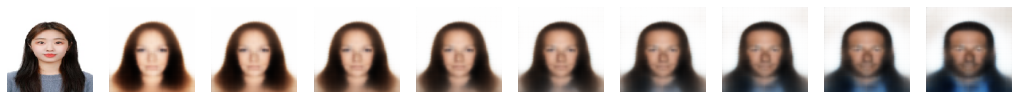

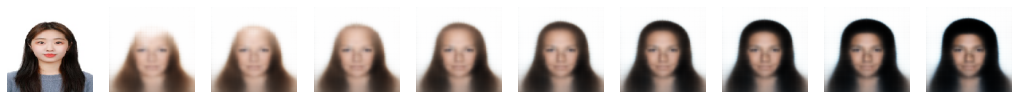

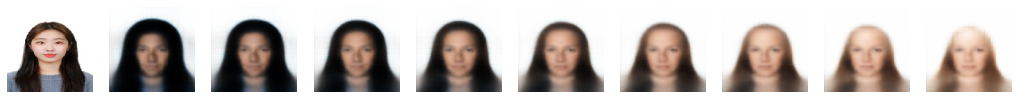

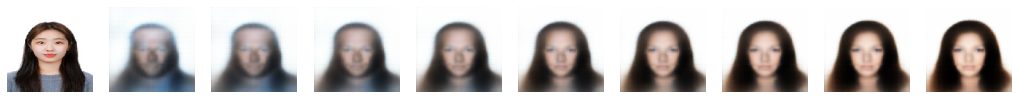

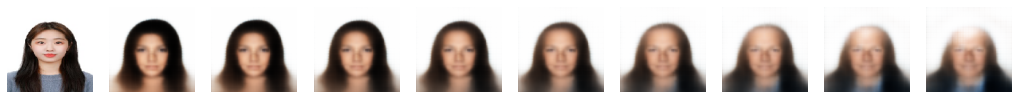

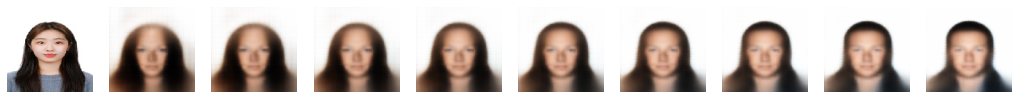

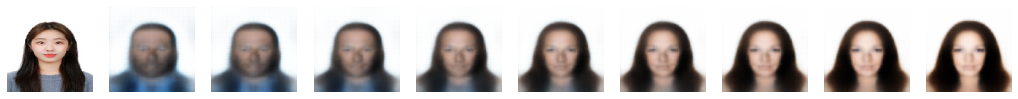

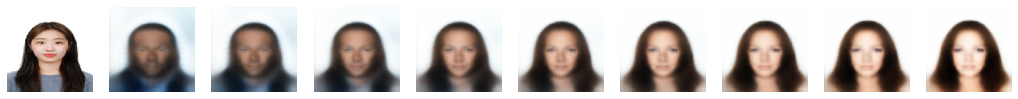

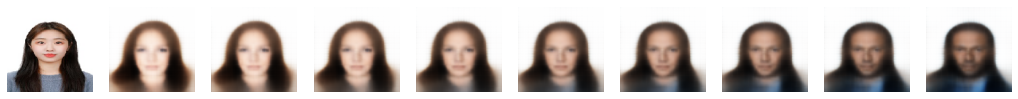

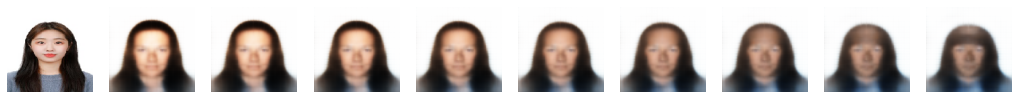

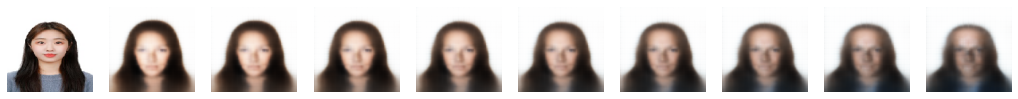

In [18]:
# print('Male Vector')
add_vector_to_images(male_vec)

# print('Blackhair Vector')
add_vector_to_images(black_hair_vec)

# print('Blondehair Vector')
add_vector_to_images(blonde_hair_vec)

# print('Brownhair Vector')
add_vector_to_images(brown_hair_vec)

# print('Grayhair Vector')
add_vector_to_images(gray_hair_vec)

# print('Straighthair Vector')
add_vector_to_images(straight_hair_vec)

# print('Wavy Vector')
add_vector_to_images(wavy_hair_vec)

# print('HeavyMakeUp Vector')
add_vector_to_images(heavy_makeup_vec)

# print('Mustache Vector')
add_vector_to_images(mustache_vec)

# print('Hat Vector')
add_vector_to_images(wearing_hat_vec)

# print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)